# LGBMRegressor and fewer features

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split 
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import itertools



df=pd.read_csv('Carbon_Emission.csv',sep=";")

#df = pd.read_csv('/kaggle/input/individual-carbon-footprint-calculation/Carbon Emission.csv')
#data can be found at https://www.kaggle.com/datasets/dumanmesut/individual-carbon-footprint-calculation/data


# change display settings to show all columns
pd.set_option('display.max_columns', None)


#rename
# rename columns: replace spaces with underscores
df.columns = df.columns.str.replace(' ', '_')
# Rename 'public' to 'public transport' and the car-typs - to make the information easier to understand
df['Vehicle_Type'] = df['Vehicle_Type'].replace({'public': 'public transport', 'petrol': 'car (type: petrol)','diesel': 'car (type: diesel)',
                                                'hybrid': 'car (type: hybrid)','lpg': 'car (type: lpg)','electric': 'car (type: electric)'})
df['Transport'] = df['Transport'].replace({'public': 'public transport', 'private': 'car'})


df.head()

,Body_Type,Sex,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public transport,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,car,car (type: petrol),never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,car,car (type: diesel),often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743


# Encoding

### variables "Transport" and "Vehicle Type"

In [19]:
##create new column "Transport Vehicle Type" 
df["Transport_Vehicle_Type"]=df["Vehicle_Type"] #create a new column
df.loc[df["Transport_Vehicle_Type"].isna(), "Transport_Vehicle_Type"] = df["Transport"] # Werte aus 'Transport' übernehmen, wenn 'Vehicle Type' NaN ist


##veranschaulichen der neuen Spalten und ihrer Werte
df[["Transport","Vehicle_Type","Transport_Vehicle_Type"]].head()

,Transport,Vehicle_Type,Transport_Vehicle_Type
0,public transport,NaN,public transport
1,walk/bicycle,NaN,walk/bicycle
2,car,car (type: petrol),car (type: petrol)
3,walk/bicycle,NaN,walk/bicycle
4,car,car (type: diesel),car (type: diesel)


### dummy-variables for: "Recycling" and "Cooking_With"

In [20]:
## dummy-variables for Recycling
unique_values_Recycling= set([item for sublist in df['Recycling'].unique() for item in eval(sublist)]) # Liste aller einzigartigen Recycling-Möglichkeiten
for item in unique_values_Recycling:
    df['Recycling_'+str(item)] = df['Recycling'].apply(lambda x: 1 if item in x else 0)

## dummy-variables for Cooking-with
unique_values_cooking_With= set([item for sublist in df['Cooking_With'].unique() for item in eval(sublist)]) # Liste aller einzigartigen Cooking_With-Möglichkeiten
unique_values_cooking_With.remove("Airfryer") #delete Cooking_with_Airfryer
for item in unique_values_cooking_With:
    df['Cooking_With_'+str(item)] = df['Cooking_With'].apply(lambda x: 1 if item in x else 0)

##########################################################################################

##create list of dummy-variables for Regression
dummy_variables = set()

columns_recycling=['Recycling_'+str(item) for item in unique_values_Recycling] #liste mit Spalten-Namen
dummy_variables.update(columns_recycling)

columns_cooking_with=['Cooking_With_'+str(item) for item in unique_values_cooking_With] #liste mit Spalten-Namen
dummy_variables.update(columns_cooking_with)

##########################################################################################


df.iloc[282:284, -13:] 

,Energy_efficiency,Recycling,Cooking_With,CarbonEmission,Transport_Vehicle_Type,Recycling_Metal,Recycling_Paper,Recycling_Plastic,Recycling_Glass,Cooking_With_Grill,Cooking_With_Stove,Cooking_With_Microwave,Cooking_With_Oven
282,No,"['Paper', 'Plastic', 'Metal']",[],1484,public transport,1,1,1,0,0,0,0,0
283,Yes,[],"['Stove', 'Grill', 'Airfryer']",2955,public transport,0,0,0,0,1,1,0,0


### Take care of categorical data: ordering values of ordinal variables

In [21]:
#ordering values of ordinal variables

# dictonary of ordinal categorical variables. perpose of this dictonary: values of categorical variables can be ordered
dict_variables_ordinal_categorical = {
    'Body_Type': ['underweight', 'normal', 'overweight', 'obese'],
    'Diet': ['vegan','vegetarian','pescatarian','omnivore'],
    'How_Often_Shower': ['less frequently','daily', 'twice a day','more frequently'],
    'Social_Activity': ['never', 'sometimes','often'],
    'Frequency_of_Traveling_by_Air': ['never', 'rarely', 'frequently', 'very frequently'],
    'Waste_Bag_Size': ['small','medium', 'large', 'extra large'],
    'Energy_efficiency': ['Yes', 'Sometimes', 'No']
}
#Kategorien definieren: Verwende pd.Categorical, um die values von ordinal categorical variables in der gewünschten Reihenfolge zu definieren. Die Option ordered=True stellt sicher, dass die Kategorien als geordnet behandelt werden.
for column, col_ordering in dict_variables_ordinal_categorical.items():
    df[column] = pd.Categorical(df[column], categories=col_ordering, ordered=True)   #chatGPT did the programming for me

#example
df['Waste_Bag_Size'].unique()

['large', 'extra large', 'small', 'medium']
Categories (4, object): ['small' < 'medium' < 'large' < 'extra large']

---
# 1.model: with all variables to find out the most important features

In [22]:
variables_ordinal = ['Body_Type','Diet','How_Often_Shower','Social_Activity','Frequency_of_Traveling_by_Air','Waste_Bag_Size','Energy_efficiency']
variables_nominal_1answer = ['Sex', 'Heating_Energy_Source','Transport_Vehicle_Type']
variables_for_one_hot_encoded = variables_ordinal + variables_nominal_1answer 

variables_quantitative = ['Monthly_Grocery_Bill', 'Vehicle_Monthly_Distance_Km', 'Waste_Bag_Weekly_Count', 'How_Long_TV_PC_Daily_Hour', 'How_Many_New_Clothes_Monthly', 'How_Long_Internet_Daily_Hour']


X = df[variables_quantitative + variables_for_one_hot_encoded + list(dummy_variables)]

# Convert categorical columns to category dtype
X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me

y = df["CarbonEmission"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, #random_state=42
)
    
    # Specify the categorical features by column names
categorical_features = variables_for_one_hot_encoded     #chatGPT wrote that for me
    
model = LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=categorical_features)

#evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_scores = r2_score(y_train, y_train_pred)
test_scores = r2_score(y_test, y_test_pred)
print(f"average R-squared (from train-set): {train_scores:.3f}")
print(f"average R-squared (from test-set): {test_scores:.3f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 680
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 24
[LightGBM] [Info] Start training from score 2278.803000
average R-squared (from train-set): 0.992
average R-squared (from test-set): 0.979



Feature Importances:
                          feature  importance
4    How_Many_New_Clothes_Monthly         382
1     Vehicle_Monthly_Distance_Km         354
2          Waste_Bag_Weekly_Count         264
0            Monthly_Grocery_Bill         205
10  Frequency_of_Traveling_by_Air         190
15         Transport_Vehicle_Type         182
11                 Waste_Bag_Size         159
6                       Body_Type         156
5    How_Long_Internet_Daily_Hour         155
13                            Sex         154
14          Heating_Energy_Source         121
9                 Social_Activity         115
7                            Diet         100
22                Recycling_Paper          80
17                Recycling_Metal          64
21                Recycling_Glass          61
12              Energy_efficiency          60
3       How_Long_TV_PC_Daily_Hour          60
16              Recycling_Plastic          46
8                How_Often_Shower          33
20          

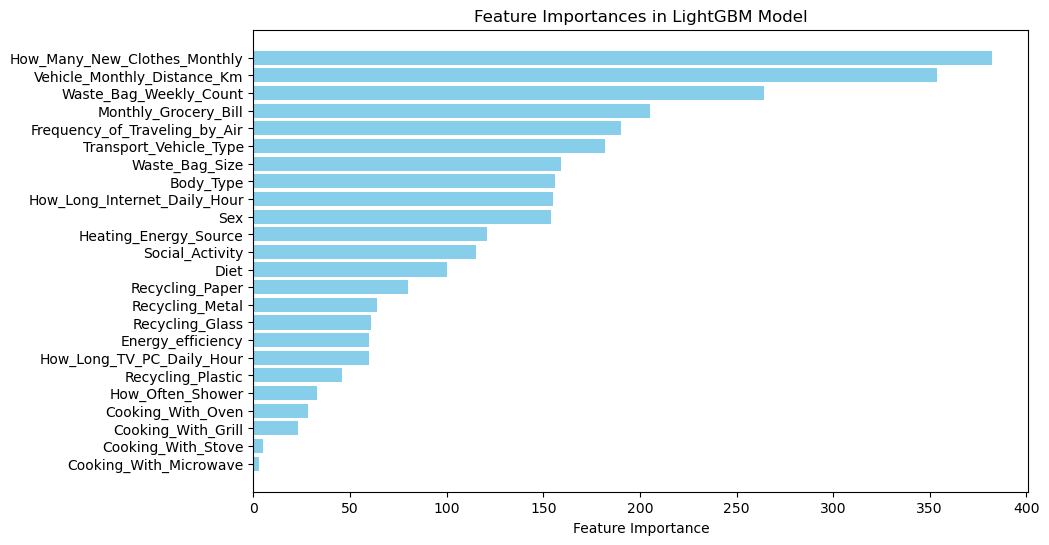

In [23]:
#chatGPT wrote this code-piece


# Extract and display feature importances
feature_importances = model.feature_importances_

# Creating a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Displaying feature importances
print("\nFeature Importances:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances in LightGBM Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

---
# 2.model: with 6 most important features has bad R-squared

if we take the 6 features:
* variables_quantitative = ["Vehicle_Monthly_Distance_Km", "How_Many_New_Clothes_Monthly", "Waste_Bag_Weekly_Count",'Monthly_Grocery_Bill']
* variables_for_one_hot_encoded = ['Body_Type', 'Transport_Vehicle_Type']

we get:
- R-squared (from train-set): 0.729
- R-squared (from test-set): 0.617

In [24]:

variables_quantitative = ["Vehicle_Monthly_Distance_Km", "How_Many_New_Clothes_Monthly", "Waste_Bag_Weekly_Count",'Monthly_Grocery_Bill']
variables_for_one_hot_encoded = ['Body_Type', 'Transport_Vehicle_Type']
dummy_variables=set()


X = df[variables_quantitative + variables_for_one_hot_encoded + list(dummy_variables)]

# Convert categorical columns to category dtype
X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me



y = df["CarbonEmission"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, #random_state=42
)
    
    # Specify the categorical features by column names
categorical_features = variables_for_one_hot_encoded     #chatGPT wrote that for me
    
model = LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=categorical_features)

#evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_scores = r2_score(y_train, y_train_pred)
test_scores = r2_score(y_test, y_test_pred)
print(f"average R-squared (from train-set): {train_scores:.3f}")
print(f"average R-squared (from test-set): {test_scores:.3f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] Start training from score 2266.162625
average R-squared (from train-set): 0.727
average R-squared (from test-set): 0.619


---

# Find out which of the 28 6-element subsets of features has the best R-squared

In [25]:
#8 columns
top8_columns=['How_Many_New_Clothes_Monthly','Vehicle_Monthly_Distance_Km','Waste_Bag_Weekly_Count','Monthly_Grocery_Bill','Transport_Vehicle_Type','Sex','Frequency_of_Traveling_by_Air','Body_Type']

#list of all possible subsets with 6 elements
subsets6 = list(itertools.combinations(top8_columns, 6))
print("Number of 6-element subsets:", len(subsets6))  #there are 28-elements in subsets6


results=[]
for columns_combination in subsets6:
    X = df[list(columns_combination)]

    # Convert categorical columns to category dtype
    variables_for_one_hot_encoded=X.select_dtypes(include=['object','category']).columns.tolist()
    X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


    y=df['CarbonEmission']
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.75)


    # Specify the categorical features by column names
    categorical_features = variables_for_one_hot_encoded     #chatGPT wrote that for me
    
    model = LGBMRegressor()
    model.fit(X_train, y_train, categorical_feature=categorical_features)

    #evaluate
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_scores = r2_score(y_train, y_train_pred)
    test_scores = r2_score(y_test, y_test_pred)

    results.append((test_scores,train_scores, columns_combination, len(columns_combination)))

# Setze die maximale Breite einer Spalte auf None, um keine Begrenzung zu haben
pd.set_option('display.max_colwidth', None)

# Create a dataframe to display results
results_df = pd.DataFrame(results, columns=['R-squared (from test-set)','R-squared (from train-set)', 'column-combination', 'number columns'])
results_df.sort_values(by='R-squared (from test-set)', ascending=False, inplace=True) #sort by Score
results_df

Number of 6-element subsets: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2261.737333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 6
[LightGBM] [Info] Start training from score 2262.638400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 

,R-squared (from test-set),R-squared (from train-set),column-combination,number columns
8,0.879579,0.907817,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Waste_Bag_Weekly_Count, Transport_Vehicle_Type, Frequency_of_Traveling_by_Air, Body_Type)",6
14,0.878709,0.910670,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Transport_Vehicle_Type, Sex, Frequency_of_Traveling_by_Air, Body_Type)",6
25,0.871831,0.894457,"(Vehicle_Monthly_Distance_Km, Waste_Bag_Weekly_Count, Transport_Vehicle_Type, Sex, Frequency_of_Traveling_by_Air, Body_Type)",6
6,0.860559,0.896714,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Waste_Bag_Weekly_Count, Transport_Vehicle_Type, Sex, Frequency_of_Traveling_by_Air)",6
26,0.849893,0.881493,"(Vehicle_Monthly_Distance_Km, Monthly_Grocery_Bill, Transport_Vehicle_Type, Sex, Frequency_of_Traveling_by_Air, Body_Type)",6
23,0.845239,0.882481,"(Vehicle_Monthly_Distance_Km, Waste_Bag_Weekly_Count, Monthly_Grocery_Bill, Transport_Vehicle_Type, Frequency_of_Traveling_by_Air, Body_Type)",6
12,0.841628,0.899335,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Monthly_Grocery_Bill, Transport_Vehicle_Type, Frequency_of_Traveling_by_Air, Body_Type)",6
1,0.840230,0.883703,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Waste_Bag_Weekly_Count, Monthly_Grocery_Bill, Transport_Vehicle_Type, Frequency_of_Traveling_by_Air)",6
10,0.834819,0.883719,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Monthly_Grocery_Bill, Transport_Vehicle_Type, Sex, Frequency_of_Traveling_by_Air)",6
21,0.815653,0.870861,"(Vehicle_Monthly_Distance_Km, Waste_Bag_Weekly_Count, Monthly_Grocery_Bill, Transport_Vehicle_Type, Sex, Frequency_of_Traveling_by_Air)",6


---

---
# 3.model: with 6 features with best R-Squared

if we take the 6 features:
'How_Many_New_Clothes_Monthly','Vehicle_Monthly_Distance_Km','Transport_Vehicle_Type','Sex','Frequency_of_Traveling_by_Air','Body_Type'

we get:
* R-squared (from test-set): 0.879579
* R-squared (from train-set): 0.907817

In [30]:
columns_combination=['How_Many_New_Clothes_Monthly','Vehicle_Monthly_Distance_Km','Waste_Bag_Weekly_Count','Transport_Vehicle_Type','Frequency_of_Traveling_by_Air','Body_Type']

X = df[columns_combination]

    # Convert categorical columns to category dtype
variables_for_one_hot_encoded=X.select_dtypes(include=['object','category']).columns.tolist()
X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


y=df['CarbonEmission']

#for final model no split in train-test-data
#X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.75)


    # Specify the categorical features by column names
categorical_features = variables_for_one_hot_encoded     #chatGPT wrote that for me
    
model = LGBMRegressor()
model.fit(X, y, categorical_feature=categorical_features)

    #evaluate
y_pred = model.predict(X)
scores = r2_score(y, y_pred)
print('R-squared:',scores)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 6
[LightGBM] [Info] Start training from score 2269.147300
R-squared: 0.9052656259709891


# save the 3.model in pkl-format

In [13]:

import pickle

#with open('model_LGBMRegressor.pkl', 'wb') as model_file:
#    pickle.dump(model, model_file)

In [17]:

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# Suppress specific warning (SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


#8 columns
top8_columns=['How_Many_New_Clothes_Monthly','Vehicle_Monthly_Distance_Km','Transport_Vehicle_Type','Sex','Frequency_of_Traveling_by_Air','Body_Type','Waste_Bag_Weekly_Count']

#list of all possible subsets with 6 elements
subsets6 = list(itertools.combinations(top8_columns, 5))
print("Number of 6-element subsets:", len(subsets6))  #there are 28-elements in subsets6


results=[]
for columns_combination in subsets6:
    X = df[list(columns_combination)]

    # Convert categorical columns to category dtype
    variables_for_one_hot_encoded=X.select_dtypes(include=['object','category']).columns.tolist()
    X[variables_for_one_hot_encoded] = X[variables_for_one_hot_encoded].astype('category')    #chatGPT wrote that for me


    y=df['CarbonEmission']
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.75)


    # Specify the categorical features by column names
    categorical_features = variables_for_one_hot_encoded     #chatGPT wrote that for me
    
    model = LGBMRegressor()
    model.fit(X_train, y_train, categorical_feature=categorical_features)

    #evaluate
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_scores = r2_score(y_train, y_train_pred)
    test_scores = r2_score(y_test, y_test_pred)

    results.append((test_scores,train_scores, columns_combination, len(columns_combination)))

# Setze die maximale Breite einer Spalte auf None, um keine Begrenzung zu haben
pd.set_option('display.max_colwidth', None)

# Create a dataframe to display results
results_df = pd.DataFrame(results, columns=['R-squared (from test-set)','R-squared (from train-set)', 'column-combination', 'number columns'])
results_df.sort_values(by='R-squared (from test-set)', ascending=False, inplace=True) #sort by Score
results_df

Number of 6-element subsets: 21
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 5
[LightGBM] [Info] Start training from score 2268.086267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 5
[LightGBM] [Info] Start training from score 2272.574667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 

,R-squared (from test-set),R-squared (from train-set),column-combination,number columns
3,0.848904,0.886907,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Transport_Vehicle_Type, Frequency_of_Traveling_by_Air, Body_Type)",5
15,0.838771,0.870185,"(Vehicle_Monthly_Distance_Km, Transport_Vehicle_Type, Sex, Frequency_of_Traveling_by_Air, Body_Type)",5
0,0.834493,0.872023,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Transport_Vehicle_Type, Sex, Frequency_of_Traveling_by_Air)",5
4,0.830742,0.871430,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Transport_Vehicle_Type, Frequency_of_Traveling_by_Air, Waste_Bag_Weekly_Count)",5
18,0.830430,0.871362,"(Vehicle_Monthly_Distance_Km, Transport_Vehicle_Type, Frequency_of_Traveling_by_Air, Body_Type, Waste_Bag_Weekly_Count)",5
16,0.829091,0.851973,"(Vehicle_Monthly_Distance_Km, Transport_Vehicle_Type, Sex, Frequency_of_Traveling_by_Air, Waste_Bag_Weekly_Count)",5
13,0.722468,0.779634,"(How_Many_New_Clothes_Monthly, Transport_Vehicle_Type, Frequency_of_Traveling_by_Air, Body_Type, Waste_Bag_Weekly_Count)",5
6,0.715026,0.793805,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Sex, Frequency_of_Traveling_by_Air, Body_Type)",5
9,0.705724,0.792519,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Frequency_of_Traveling_by_Air, Body_Type, Waste_Bag_Weekly_Count)",5
10,0.692554,0.778143,"(How_Many_New_Clothes_Monthly, Transport_Vehicle_Type, Sex, Frequency_of_Traveling_by_Air, Body_Type)",5
